<div align="center">
  <img src="https://www.dropbox.com/s/vold2f3fm57qp7g/ECE4179_5179_6179_banner.png?dl=1" alt="ECE4179/5179/6179 Banner" style="max-width: 60%;"/>
</div>

<div align="center">

# Sentiment Analysis with Logistic Regression

</div>

Welcome to **ECE4179/5179/6179 Week 3**! Our primary objective in this notebook is to introduce the concept of **logistic regression** and its application in **binary classification**. We will use our knowledge to determine the sentiment of a given text. Sentiment analysis is to determine the attitude of a speaker or a writer with respect to some topic or the overall contextual polarity of a document. The attitude may be his or her judgment or evaluation (see [Wikipedia](https://en.wikipedia.org/wiki/Sentiment_analysis)). Sentiment analysis is widely applied to reviews and social media for a variety of applications, ranging from marketing to customer service. We will show how we can build a sentiment analysis model using a simple linear classifier and a Large Language Model (LLM). How exciting!



<p align="center">
<img src="data/sent_classifier.png" alt="drawing" width="600"/>
</p>








Let's get started! In this notebook, we will use the following Python packages:

- [torch](https://pytorch.org/) is the PyTorch package for deep learning implementation.
- [transformers](https://huggingface.co/transformers/) is a state-of-the-art library for Natural Language Processing (NLP) tasks.
- [datasets](https://huggingface.co/docs/datasets/) is a library for easily accessing and processing datasets.
- [NumPy](https://numpy.org/) is a package for scientific computing with Python.
- [Matplotlib](https://matplotlib.org/) is a comprehensive library for creating visualizations in Python.
- [Pandas](https://pandas.pydata.org/) is a package for data analysis.
- [Scikit-learn](https://scikit-learn.org/stable/) is a comprehensive package for machine learning in Python.
- [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) is a Python library that provides interactive HTML widgets for Jupyter notebooks.
- [tqdm](https://tqdm.github.io/) is a package that allows for visualizing the progress of tasks in Python.


In [1]:
# Enable autoreload extension
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import torch

from tqdm import tqdm

RND_SEED = 42
np.random.seed(RND_SEED)  # For reproducibility
torch.manual_seed(RND_SEED)  # PyTorch random seed


In [3]:
#=========================================================================================================
# plot the decision boundary
def plot_decision_boundary(X, y, model):

    # let's first compute the accuracy of the logistic regression model
    y_pred_data = model.predict(X) # predictions on the original data

    accuracy = accuracy_score(y, y_pred_data)
    # precision = precision_score(y, y_pred_data)
    # recall = recall_score(y, y_pred_data)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # get the min and max of the first feature
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # get the min and max of the second feature

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), # create a meshgrid
                         np.arange(y_min, y_max, 0.02))

    x_grid = np.c_[xx.ravel(), yy.ravel()] # create a grid of points

    y_pred = model.predict(x_grid) # predict the class of each point in the grid

    plt.figure(figsize=(8, 6))
    # Create mask for positive and negative classes
    pos_idx = y == 1
    neg_idx = y == 0

    # Plot positive and negative points
    plt.scatter(X[pos_idx, 0], X[pos_idx, 1], c='r', alpha=0.6, edgecolors='k', marker='o', s=50, label='Positive class')
    plt.scatter(X[neg_idx, 0], X[neg_idx, 1], c='b', alpha=0.6, edgecolors='k', marker='s', s=50, label='Negative class')



    # Plot the decision boundary
    plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.2)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    # plt.title(f'Logistic Regression\nAccuracy: {accuracy:.2f} Precision: {precision:.2f} Recall: {recall:.2f}')
    plt.title(f'Logistic Regression\nAccuracy: {accuracy:.2f}')

    # Display the legend
    plt.legend()
    plt.show()


## Understanding Logistic Regression

Logistic regression is a linear classification method for binary problems. To better understand its workings, we start by applying the algorithm to a toy dataset. The steps of the algorithm are as follows:

1. **Initialize the weights and bias**:
   - Initialize the weights $\mathbf{w}$ to small random values or zeros.

2. **Compute the prediction**:
   - For each data point $\color{pink}{\big(\mathbf{x}_i, y_i\big)}$, compute the logistic regression's prediction, denoted by $\color{pink}{\hat{y}}$, which is determined by the expression 
   \begin{align} 
   \hat{y}_i = \sigma\big(\mathbf{w}^\top\mathbf{x}_i\big)\;,
   \end{align}
   where $\sigma$ is the sigmoid function defined as:
   \begin{align} 
   \sigma(x) = \frac{1}{1 + \exp{(-x)}}\;.
   \end{align}

3. **Compute the loss**:
   - The loss function for logistic regression is the binary cross-entropy loss, given by:
   \begin{align} 
   \mathcal{L} = -\frac{1}{m}\sum_{i=1}^m \Big[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \Big]\;,
   \end{align}
   where $m$ is the number of data points.

4. **Update the weights**:
   - Underneath, weights are updated using gradient descent. The update rules are:
   \begin{align} 
   \mathbf{w} &\leftarrow \mathbf{w} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{w}}\;,
   \end{align}
   where $\eta$ is the learning rate, and the gradients are computed as:
   \begin{align} 
   \frac{\partial \mathcal{L}}{\partial \mathbf{w}} &= \frac{1}{m}\sum_{i=1}^m (\hat{y}_i - y_i) \mathbf{x}_i\;.
   \end{align}

5. **Repeat steps 2 to 4**:
   - Continue iterating through steps 2 to 4 until convergence is achieved. This occurs when the change in the loss function is below a certain threshold or a specified number of iterations is reached.

### Toy dataset
We will use a toy dataset that consists of two classes, each with two features. The data points are plotted below and as you can see is linearly separable. Our first goal is to design and train a perceptron to classify the data points into their respective classes. Note that the red class is labeled as $+1$ and the blue class is labeled as $-1$.


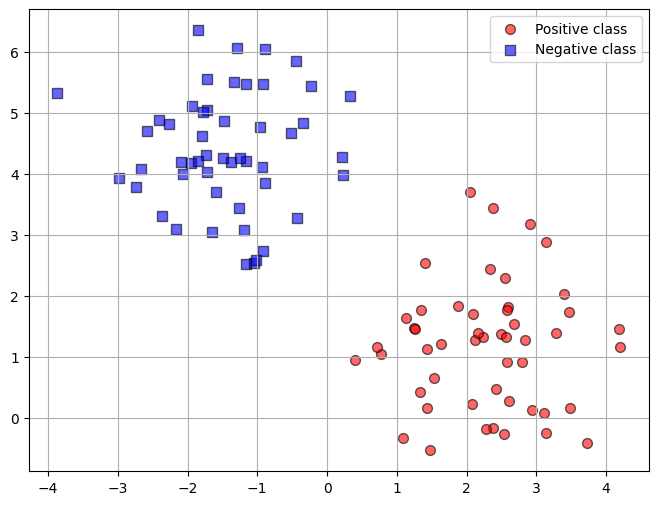

In [4]:
# !pip install -U scikit-learn

from sklearn.datasets import make_blobs
# Create a 2D toy dataset from two Gaussian distributions
# with 100 samples each, 2 features each, and 2 classes
# with 1 cluster per class


X, y = make_blobs(n_samples=100, n_features=2, 
                  cluster_std=1.0, centers=2, center_box=(-5.0, 5.0),
                  random_state=RND_SEED)

# X is a 2D array of shape (100, 2), each row is a sample
# y is a 1D array of shape (100,), each element is a class label (0 or 1)
pos_idx = y == 1
neg_idx = y == 0

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[pos_idx, 0], X[pos_idx, 1], c='r', alpha=0.6, edgecolors='k', marker='o', s=50, label='Positive class')
plt.scatter(X[neg_idx, 0], X[neg_idx, 1], c='b', alpha=0.6, edgecolors='k', marker='s', s=50, label='Negative class')
plt.grid(True)
plt.legend(loc='best')
plt.show()

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #1.</span>  Working with Logistic Regression
Your task is to use the  `LogisticRegression` class from the `sklearn.linear_model` module. This method is efficient and widely used in practice. The good thing about the sklearn implementation is that it takes care of the optimization process for you. In other words, you don't have to worry the learning rate. 
</div>

<details>
<summary style="color: yellow; font-weight: bold;">Show Answer</summary>
    
```python
from sklearn.linear_model import LogisticRegression


# Initialize the LogisticRegression model
model = LogisticRegression()

# Fit the model to the data
model.fit(X, y)

# Retrieve the weights (coefficients) and bias (intercept)
weights = model.coef_[0]
bias = model.intercept_[0]

print("Weights:", weights)
print("Bias:", bias)
```


In [11]:
from sklearn.linear_model import LogisticRegression

# Use the LogisticRegression class from scikit-learn and fit method to train the model
# TODO <--- write your code here

model = LogisticRegression(max_iter=100, random_state=RND_SEED)
model.fit(X,y)
# Print the weights and bias of the trained model
weights = model.coef_[0]
bias = model.intercept_

print(f'Weights: {weights}')
print(f'Bias: {bias}')

Weights: [ 1.86509105 -1.29676789]
Bias: [2.82414335]


<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">



### <span style="color: pink;">Task #2.</span>  Study the trained model
Use plot_decision_boundary to plot the decision boundary for the weights and biases of your model. The plot_decision_boundary also reports some numbers in its title, can you figure out what they are?  
</div>

<details>
<summary style="color: yellow; font-weight: bold;">Show Answer</summary>


For your convenience, we have provided a function to plot the decision boundary of the logistic regression model. Recall that the decision boundary is the line that separates the two classes. The function is called `plot_decision_boundary` and can be called as shown below.

```python
plot_decision_boundary(X, y, model)
# X: data (each row is a sample)
# y: labels (each row is a label)
# model: trained logistic regression model
```


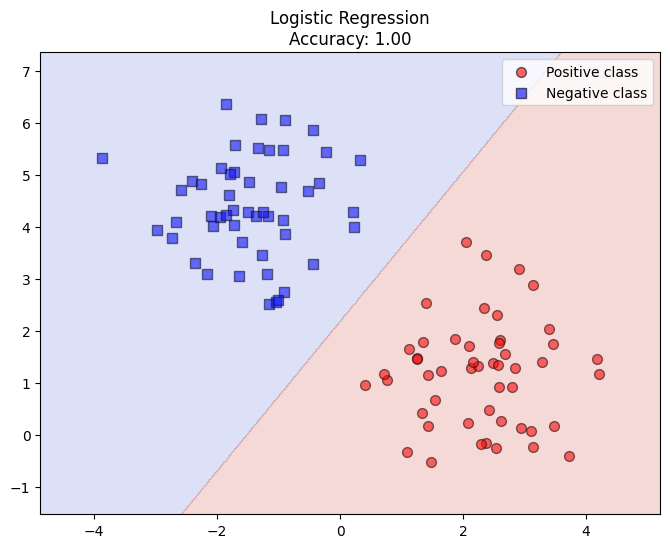

In [12]:
# use the plot_decision_boundary function to plot the decision boundary

# TODO <--- write your code here

plot_decision_boundary(X,y,model)

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #3.</span>  A more difficult problem
Patterns are not always linearly separable. In this task, we will work with a dataset that is not linearly separable. The data points are plotted below. Your task is to train a logistic regression model on this dataset and plot the decision boundary.
</div>





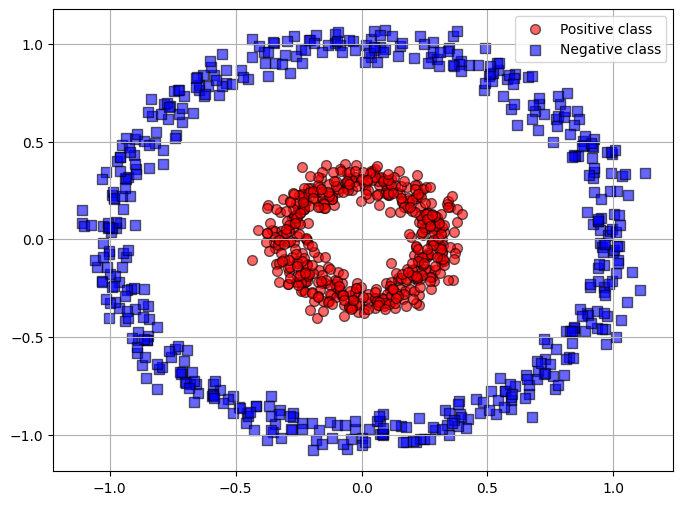

In [13]:
from sklearn.datasets import make_circles
X_circ, y_circ = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)



# X is a 2D array of shape (100, 2), each row is a sample
# y is a 1D array of shape (100,), each element is a class label (0 or 1)
pos_idx = y_circ == 1
neg_idx = y_circ == 0

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_circ[pos_idx, 0], X_circ[pos_idx, 1], c='r', alpha=0.6, edgecolors='k', marker='o', s=50, label='Positive class')
plt.scatter(X_circ[neg_idx, 0], X_circ[neg_idx, 1], c='b', alpha=0.6, edgecolors='k', marker='s', s=50, label='Negative class')
plt.grid(True)
plt.legend(loc='best')
plt.show()

Weights: [-7.5340172  -7.53994849]
Bias: [4.02301977]


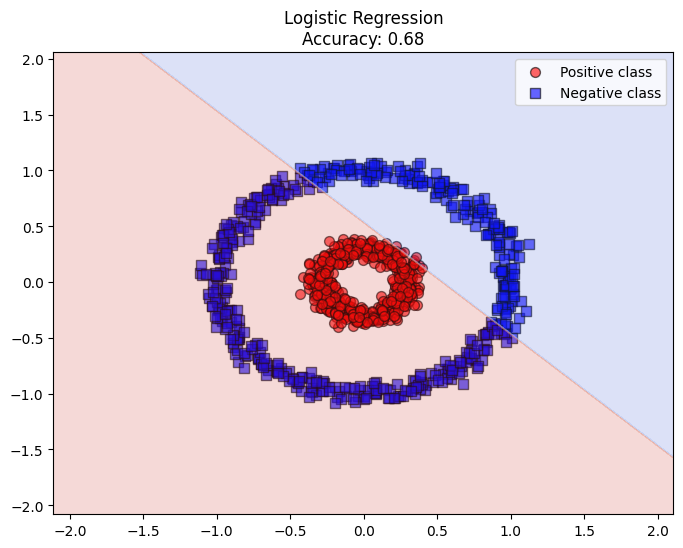

In [22]:
# Again, use the LogisticRegression class from scikit-learn and fit method to train the model on the circular dataset
# TODO <--- write your code here
model1 = LogisticRegression(max_iter=1000, random_state=RND_SEED)

model.fit(X_circ,y_circ)
# Print the weights and bias of the trained model
weights = model.coef_[0]
bias = model.intercept_

print(f'Weights: {weights}')
print(f'Bias: {bias}')

# Print the weights and bias of the trained model on the circular dataset
# TODO <--- write your code here


# use the plot_decision_boundary function to plot the decision boundary on the circular dataset
# TODO <--- write your code here
plot_decision_boundary(X_circ,y_circ,model)

<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #4.</span>  Can you improve the model?
You have learned about polynomial features in the previous weeks. Can you improve the model by adding polynomial features to the data?
</div>

Weights: [-7.5340172  -7.53994849]
Bias: [4.02301977]


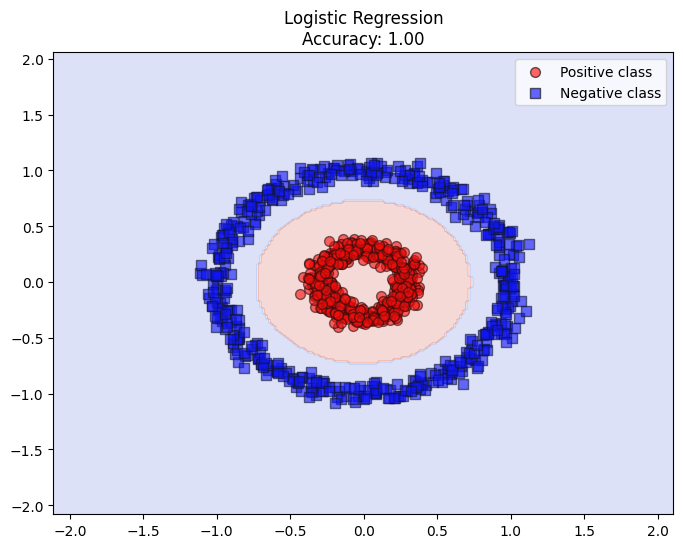

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Use the PolynomialFeatures class from scikit-learn to create a polynomial feature transformer
# and then use the LogisticRegression class from scikit-learn to train the model
# opt for choosing a polynomial with minimum degree that can separate the two classes
nl_encoder = PolynomialFeatures(degree=2)
model2 = LogisticRegression(max_iter=1000, random_state=RND_SEED)

# TODO <--- write your code here
model_pipeline = Pipeline([('nl_encoder',nl_encoder), ('model', model2)])

model_pipeline.fit(X_circ,y_circ)

weights = model.coef_[0]
bias = model.intercept_

print(f'Weights: {weights}')
print(f'Bias: {bias}')

plot_decision_boundary(X_circ,y_circ,model_pipeline)


### GPT-2


GPT-2 is a next-word prediction model developed by OpenAI and is the ancestor of chatGPT.
 It predicts the most probable word based on the context provided by all the words fed into it. In this sense, we can say that the GPT-2 is basically the next word prediction feature of a keyboard app, but one that is much larger and more sophisticated than what your phone has. 
<br>
<br>

Let's looks how GPT-2 works!
<br>
<p align="center">
<img src="data/gpt-2-output.gif" alt="drawing" width="600"/>
</p>

For this task we are going to use `transformers` library from [Hugging Face🤗](https://huggingface.co/docs/transformers/index). Hugging Face is an open-source framework which provides an easy and cost-free way to work with a wide variety of open-source models including vision,language and audio models.

We will use the [IMDB](https://huggingface.co/datasets/imdb) dataset from Hugging Face. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We are going to use  a set of 1,000 highly polar movie reviews for training, and 1,000 for testing.

In this task, we are going to get the representation of movie reviews, and use `Logistic rRegression` from scikit-learn library to classify these representations as $\textcolor{green}{\mathbf{Positive}}$ or $\textcolor{red}{\mathbf{Negative}}$ .

<p align="center">
<img src="data/model_sent.png" alt="drawing" width="600"/>
</p>

In [29]:
# if you have not installed the transformers and datasets library, you can install it using the following command

!pip install transformers -q
!pip install datasets -q

In [30]:
train_df = pd.read_csv('data/imdb_tiny_train.csv')
test_df = pd.read_csv('data/imdb_tiny_test.csv')

# Printing the first 5 rows of the training data
train_df.head()

,text,label
0,"Dumb is as dumb does, in this thoroughly unint...",0
1,I dug out from my garage some old musicals and...,1
2,After watching this movie I was honestly disap...,0
3,This movie was nominated for best picture but ...,1
4,Just like Al Gore shook us up with his painful...,1


### Tokenization

However, language models can not directly understand natural language texts. They can only process numbers, so we need to find a way to convert the raw text to numbers. We use a process called `tokenization` tokenization to find the most meaningful representation — that is, the one that makes the most sense to the model — and, if possible, the smallest representation.

Tokenization process does two main functions.
1. Split the raw text into words, sub-words or characters, which we call as **tokens**.
2. Represent each token to a unique ID.


The model uses these IDs to identify each word.

<!-- ![tokenization](tokenization.png) -->

<p align="center">
<img src="data/tokenization.png" alt="drawing" width="600"/>
</p>

### Load the GPT-2 model and its tokenizer

We will use the `GPT2Tokenizer` from the `transformers` library to tokenize the text. I have to add that you can find SOTA LLMs such as LLAMA3 (Meta), Phi-3 (Microsoft), Gemma2 (Google), and many more in the Hugging Face model hub. Interestingly, many models on the [arena leaderboard](https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard) are available for you to use, and if you have a good machine, you can use a bigger and more powerful model. I leave exploring these models to you as an exercise, and use GPT-2 in the workshop. 

In [31]:
from transformers import AutoTokenizer, AutoModel 


torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch_device)


gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt_model = AutoModel.from_pretrained("gpt2", pad_token_id=gpt_tokenizer.eos_token_id).to(torch_device)

cpu


c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cgreg\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Let's see the tokenization process using GPT-2.

A language model process the text in two stages. First, it uses a model called Tokenizer to convert the  text into a list of numerical values. Then, these numerical values are processed by a neural network  to generate the output.


If a tokenizer does not know a word, either it will split it into subwords or it will replace sub-word tokens
or it will replace the word with the unknown token $(<\text{unk}>)$. 

In [32]:
text = "Hello from the ECE4179 workshop"
tokens = gpt_tokenizer.encode(text, return_tensors='np').squeeze()
print(tokens)
print('*'*50)
# Decode the tokens
for token in tokens:
    decoded_token = gpt_tokenizer.decode([token])
    print(f"{token} --> {[decoded_token]}")

[15496   422   262   412  5222    19 21738 20243]
**************************************************
15496 --> ['Hello']
422 --> [' from']
262 --> [' the']
412 --> [' E']
5222 --> ['CE']
19 --> ['4']
21738 --> ['179']
20243 --> [' workshop']


Now, let's feed the model with a new sentence and see its output.

<p align="center">
<img src="data/pred.png" alt="drawing" width="750"/>
</p>


In [33]:
# Encode the input text
inputs = gpt_tokenizer.encode(text, return_tensors='pt').to(torch_device)

# Feed the input to the model
outputs = gpt_model(inputs)

z = outputs["last_hidden_state"].detach().cpu().numpy().squeeze()

print(f'Input shape: {inputs.shape}')
print(f'Output shape: {z.shape}')

Input shape: torch.Size([1, 8])
Output shape: (8, 768)


You can see, the output is 8x768, which means that we have 8 tokens in the sentence and each token is represented by a 768-dimensional vector. For simplicity, we will use the average of all the tokens as the sentence representation.

In [34]:
z = np.mean(z, axis=0) # Average the embeddings of all tokens
print(f'Output Average shape: {z.shape}')

Output Average shape: (768,)


We use two helper functions to process the text in batches and get the review representation. The first function is `process_batch` which takes a list of reviews and returns the average of each review as above. The second function is `process_dataset` which takes the dataset and split the dataset to batches and process each batch using the `process_batch` function.

In [35]:
def process_batch(text_batch, tokenizer, model, device='cpu'):
    """Preprocess a batch of text for sentiment analysis.

    Args:
        text_batch (list): A list of strings to be processed.

    Returns:
        list: A list of processed strings.
    """


    tokenizer.pad_token = tokenizer.eos_token
    # Tokenize the text. Note that the encode method does not work for batches
    inputs = tokenizer(text_batch, padding=True, truncation=True, max_length=1024, return_tensors='pt').to(device)
 

    if model.device != device:
        model.to(device)  # Move model to GPU if available
    with torch.inference_mode():  # No need to calculate gradients
        # Feed the input to the model. These are not ids anymore and ** is used to unpack the dictionary
        outputs = model(**inputs) 

    z = outputs.last_hidden_state.cpu().numpy()  # Move outputs back to CPU
    z = z.mean(axis=1)  # Average over sequence length

    return z



# Function to transform a dataset in batches
def process_dataset(dataset, tokenizer, model, batch_size=8, device='cpu'):
    X = []
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch_texts = dataset[i:i+batch_size]
        batch_outputs = process_batch(batch_texts, tokenizer, model, device=device)
        X.extend(batch_outputs)
    return np.array(X)

### Process the training and testing datasets

We will process the training and testing datasets using the `process_dataset` function. The function will return the representations of the reviews in the training and testing datasets. We will use these representations to train and evaluate the logistic regression model.

In [37]:
X_train = process_dataset(train_df['text'].tolist(), gpt_tokenizer, gpt_model, device=torch_device)
X_test = process_dataset(test_df['text'].tolist(), gpt_tokenizer, gpt_model, device=torch_device)

y_train = train_df['label'].values
y_test = test_df['label'].values


# # # if you could not run GPT2 on your laptop, you can just load the data via the following code
# X_train = np.load('data/ECE4179_GPT2_data.npz')['X_train']
# X_test = np.load('data/ECE4179_GPT2_data.npz')['X_test']
# y_train = np.load('data/ECE4179_GPT2_data.npz')['y_train']
# y_test = np.load('data/ECE4179_GPT2_data.npz')['y_test']

100%|██████████| 125/125 [19:14<00:00,  9.24s/it]



<div style="background-color: #3352FF; color: white; padding: 10px; border-radius: 5px;">

### <span style="color: pink;">Task #5.</span>  Use a logistic regression model to perform sentiment analysis on the IMDB dataset.

</div>


In this task, you will use the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from sklearn to train a logistic regression model. Evaluate your model on the test data and discuss your findings.

<p align="center">
<img src="data/final_pred.png" alt="drawing" width="800"/>
</p>

<details>
<summary style="color: yellow; font-weight: bold;">Show Answer</summary>

```python

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a Logistic Regression model
model = LogisticRegression(random_state=RND_SEED, 
                           max_iter=1000,
                           solver='saga')
model.fit(X_train, y_train)

# Predict the test set
y_pred = model.predict(X_test)

# Calculate the accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
''' 
</details>


In [38]:
# Now that you have processed the text using GPT2, you can use the processed data to train a logistic regression model
# train a logistic regression model on the processed data and evaluate the model using the test data
# TODO <--- write your code here
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = LogisticRegression(random_state=RND_SEED, max_iter=1000, solver='saga')
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuray: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuray: 0.80
Precision: 0.82
Recall: 0.76
F1 Score: 0.79


c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Test your model 

How about we test our model with some recent movie reviews? Let's see how our model performs on these reviews. I have provided a function called `predict_sentiment` that takes a review and returns the sentiment of it. I also checked the reviews for `Deadpool & Wolverine' and here are two reviews for you to test your model.

Review 1: "The Bloodiest Mayhem Of The Century! We've waited so long for this moment, and it was beyond fun, wholesome, full of surprises, emotional and epic! Ryan Reynolds, Hugh Jackman and Shawn Levy pour out their hearts for this movie to be what is it."

Review 2: "This isnt a movie, its a checklist.See, i need a little thing called motivation. Its why i could not just sit back and enjoy the movie. I need a real story and I need to figure out why the character is doing what they are doing and this whole movie just felt like stuff happening for no real reason. Does this movie have a story....eh...not really. Its just stuff happening. Just Deadpool and Wolverine fighting again, and again. Lets try stabbing Deadpool some more. That didnt work the first 100 times, but maybe it will work now. No slicing, no dicing, just stabbing, which is easier on the sfx department. Sure the fight scenes were cool I guess. But not amazing."

In [39]:
def predict_sentiment(text, language_model, language_tokenizer, clf):
    # Encode the input text
    inputs = language_tokenizer.encode(text, return_tensors='pt').to(torch_device)

    # Feed the input to the model
    outputs = language_model(inputs)

    # Extract and average the hidden states
    z = outputs.last_hidden_state.cpu().detach().numpy()
    z = z.mean(axis=1)

    # Predict sentiment using the classifier
    y_pred = clf.predict(z)

    print(f"Sentiment Polarity: {'Positive' if y_pred[0] else 'Negative'}")


In [40]:
text1 = "The Bloodiest Mayhem Of The Century! We've waited so long for this moment, and it was beyond fun, wholesome, full of surprises, emotional and epic! Ryan Reynolds, Hugh Jackman and Shawn Levy pour out their hearts for this movie to be what is it."
text2 ="This isnt a movie, its a checklist.See, i need a little thing called motivation. Its why i could not just sit back and enjoy the movie. I need a real story and I need to figure out why the character is doing what they are doing and this whole movie just felt like stuff happening for no real reason. Does this movie have a story....eh...not really. Its just stuff happening. Just Deadpool and Wolverine fighting again, and again. Lets try stabbing Deadpool some more. That didnt work the first 100 times, but maybe it will work now. No slicing, no dicing, just stabbing, which is easier on the sfx department. Sure the fight scenes were cool I guess. But not amazing."


predict_sentiment(text1,gpt_model,gpt_tokenizer,model)
predict_sentiment(text2,gpt_model,gpt_tokenizer,model)


Sentiment Polarity: Positive
Sentiment Polarity: Negative


# Conclusion
In this notebook, we explored binary classification tasks. Here are the key takeaways:

### Logistic Regression and Decision Boundaries:

We used logistic regression to classify data points and visualized decision boundaries. We learned that a logistic regression model can only classify linearly separable data. Using polynomial features, we can employ logistic regression to classify non-linear data.

### Sentiment Analysis with GPT-2

We used GPT-2, a language model developed by OpenAI along with a logistic regression model to perform sentiment analysis on the IMDB dataset. For each review, we tokenized the text data and used the average output of GPT2 as text representation. We trained a logistic regression model on the resulting representations and evaluated the model on the test data and some reviews from the latest movie `Deadpool & Wolverine'.


### Want to do more?

- Try using a different language model such as BERT, LLAMA, or Phi-3 for sentiment analysis.

- If you use an instruct model, you can also prepare a response to the negative reviews. Certain models in the transformer library have generate method that can be used to generate text. Check this [page](https://huggingface.co/openai-community/gpt2) to learn about generating text with GPT2.